In [1]:
from pathlib import Path
from typing import Sequence
from functools import lru_cache

import torch
from torch import nn
from torch.utils.data import DataLoader
import torchvision
import torch.nn.functional as F
import albumentations as A
from albumentations.pytorch import ToTensorV2
from tqdm import tqdm

import matplotlib.pyplot as plt
import cv2
import numpy as np
import random

In [2]:
torch.__version__

'2.1.0+cu118'

In [3]:
torchvision.__version__

'0.16.0+cu118'

In [4]:
cv2.__version__

'4.8.1'

# Dataset

In [2]:
image_size = 256
longest_side = 512
batch_size = 8

In [3]:
class ImagePairDataset(torch.utils.data.Dataset):
    def __init__(
        self,
        content_root: str,
        style_root: str,
        transform=None,
    ):
        self.content_root = Path(content_root)
        self.style_root = Path(style_root)
        self.transform = transform
        self.contents = list(self.content_root.glob("**/*.jpg"))
        self.styles = list(self.style_root.glob("*"))

    def __len__(self) -> int:
        # return 30000
        return len(self.contents) # * len(self.styles)

    def __getitem__(self, idx: int):
        content, _, _ = self.get_content_img(idx)
        style, _, _ = self.get_style_img()

        if self.transform:
            kwargs = dict(image=content)
            transformed = self.transform(**kwargs)
            content = transformed["image"]

            kwargs = dict(image=style)
            transformed = self.transform(**kwargs)
            style = transformed["image"]

        return content, style
    
    def get_content_img(self, idx: int):
        collection = self.contents
        idx = idx % len(self.contents)

        return self.get_img(collection[idx].as_posix())
    
    def get_style_img(self):
        collection = self.styles
        idx = random.randint(0, len(self.styles)-1) # idx // len(self.contents)

        # if not is_content: print(idx)

        return self.get_img(collection[idx].as_posix())

    @lru_cache
    def get_img(self, filename: str) -> tuple[np.ndarray, int, int]:
        img = cv2.imread(filename)[:, :, ::-1]
        h, w, _ = img.shape

        return img, h, w


In [4]:
transform = A.Compose([
    A.HorizontalFlip(),
    A.augmentations.geometric.resize.SmallestMaxSize(longest_side),
    A.RandomResizedCrop(image_size, image_size),
    A.Normalize(),
    ToTensorV2(),
])

In [5]:
dataset = ImagePairDataset("../../../data/coco", "../../../data/styles", transform)

In [6]:
len(dataset)

123287

In [10]:
dataset[5][0].shape, dataset[5][1].shape

(torch.Size([3, 256, 256]), torch.Size([3, 256, 256]))

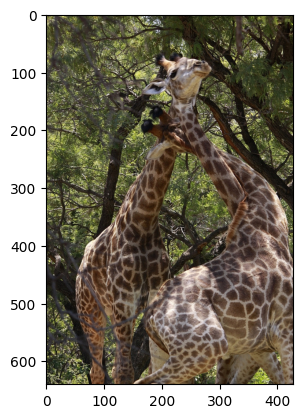

In [11]:
plt.imshow(dataset.get_content_img(10)[0])

In [7]:
loader = DataLoader(
    dataset,
    batch_size=batch_size,
    shuffle=True,
    drop_last=True,
    pin_memory=True,
    # num_workers=4,
)

In [8]:
for a, b in loader:
  print(a.shape, b.shape)
  break

torch.Size([8, 3, 256, 256]) torch.Size([8, 3, 256, 256])


# Model

In [6]:
def calc_std(x: torch.Tensor, dim: Sequence[int], keepdim: bool = False, eps: float = 1e-5) -> torch.Tensor:
  return (torch.var(x, dim, keepdim=keepdim) + eps).sqrt()

In [7]:
class AdaInEncoder(nn.Module):
  def __init__(self, fronzen: bool = True):
    super(AdaInEncoder, self).__init__()
    self.encoder = self.build_backbone(fronzen)

  def build_backbone(self, fronzen: bool = True):
    model = torchvision.models.vgg19(weights='DEFAULT', progress=True).to(device)
    if fronzen:
      for parameter in model.parameters():
        parameter.requires_grad = False
      model = model.eval()

    return model.features[:21]

  def forward(self, content:torch.Tensor) -> torch.Tensor:
    return self.encoder(content)

  def feature_forward(self, x:torch.Tensor) -> list[torch.Tensor]:
    # relu_1_1, 2_1, 3_1, 4_1: 1, 6, 11, 20
    features = []

    feature = x
    for i, layer in enumerate(self.encoder):
      feature = layer(feature)

      if i in [1, 6, 11, 20]:
        features.append(feature)

    return features

In [16]:
# AdaInEncoder()(torch.randn((8, 3, 256, 256))).shape

In [17]:
# a = AdaInEncoder().feature_forward(torch.randn((8, 3, 256, 256)))
# len(a), [_.shape for _ in a]

In [8]:
class AdaptiveInstanceNormalization(nn.Module):

  def __init__(self, content: torch.Tensor, style: torch.Tensor):
    super(AdaptiveInstanceNormalization, self).__init__()
    self.mu_content = content.mean((2,3), keepdim=True)
    self.beta_style = style.mean((2,3), keepdim=True)

    self.sigma_content = calc_std(content, (2,3), keepdim=True)
    self.gamma_style = calc_std(style, (2,3), keepdim=True)

  def forward(self, x:torch.Tensor) -> torch.Tensor:
    return self.gamma_style * (x - self.mu_content) / self.sigma_content + self.beta_style

In [19]:
# AdaptiveInstanceNormalization(torch.randn((8, 512, 32, 32)), torch.randn((8, 512, 32, 32)))(torch.randn((8, 512, 32, 32))).shape

In [9]:
# mirror encoder
class DecoderBlock(nn.Module):
  def __init__(self, layer_number: int, input_ch: int, output_ch: int, upsample: bool = True, drop_channel_first: bool = False):
    super(DecoderBlock, self).__init__()

    layers = [
        nn.ReflectionPad2d(1),
        nn.Conv2d(input_ch, input_ch // 2 if drop_channel_first else input_ch, 3, 1, 0),
        nn.ReLU(inplace=True),
    ]
    for i in range(1, layer_number):
      layers.append(nn.ReflectionPad2d(1))
      layers.append(nn.Conv2d(input_ch, output_ch if i+1 == layer_number else input_ch, 3, 1, 0))
      layers.append(nn.ReLU(inplace=True))

    self.layers = nn.Sequential(*layers)
    self.upsample = nn.UpsamplingNearest2d(scale_factor=2) if upsample else nn.Identity()

  def forward(self, x:torch.Tensor) -> torch.Tensor:
    y = self.layers(x)
    y = self.upsample(y)

    return y

class Decoder(nn.Module):

  def __init__(self):
    super(Decoder, self).__init__()
    self.block1 = DecoderBlock(1, 512, 256, drop_channel_first=True)
    self.block2 = DecoderBlock(4, 256, 128)
    self.block3 = DecoderBlock(2, 128, 64)
    self.block4 = DecoderBlock(2, 64, 3, upsample=False)

  def forward(self, x:torch.Tensor) -> torch.Tensor:
    y = self.block1(x)
    y = self.block2(y)
    y = self.block3(y)
    y = self.block4(y)
    return y

In [10]:
# Decoder()(torch.randn((8, 512, 32, 32))).shape

In [11]:
class AdaInTrainer(nn.Module):

  def __init__(self, fronzen: bool = True):
    super(AdaInTrainer, self).__init__()
    self.encoder = AdaInEncoder(fronzen)
    self.decoder = Decoder()

  def forward(self, content:torch.Tensor, style:torch.Tensor, alpha:float=1,) -> torch.Tensor:
    content_feature_map = self.encoder(content)
    style_feature_map = self.encoder(style)

    adain = AdaptiveInstanceNormalization(content_feature_map, style_feature_map)
    normalized = (1 - alpha) * content_feature_map + alpha * adain(content_feature_map)

    generated = self.decoder(normalized)

    return generated

  def style_interpolation_forward(self, content:torch.Tensor, styles:torch.Tensor, weights:torch.Tensor) -> torch.Tensor:
    content_feature_map = self.encoder(content)
    styles_feature_map = self.encoder(styles)

    normalized = torch.zeros_like(content_feature_map)
    for style_feature_map, weight in zip(styles_feature_map, weights):
      adain = AdaptiveInstanceNormalization(content_feature_map, style_feature_map.unsqueeze(0))
      normalized += weight * adain(content_feature_map)

    generated = self.decoder(normalized)

    return generated

  def loss_forward(self, content:torch.Tensor, style:torch.Tensor) -> tuple[list[torch.Tensor], torch.Tensor, list[torch.Tensor]]:
    content_feature = self.encoder(content)
    style_features = self.encoder.feature_forward(style)

    adain = AdaptiveInstanceNormalization(content_feature, style_features[-1])
    normalized = adain(content_feature)
      
    generated = self.decoder(normalized)

    generated_features = self.encoder.feature_forward(generated)

    return generated_features, normalized, style_features

In [12]:
# AdaInTrainer()(torch.randn((8, 3, 256, 256)), torch.randn((8, 3, 256, 256))).shape

In [13]:
# a, b, c = AdaInTrainer().loss_forward(torch.randn((8, 3, 256, 256)), torch.randn((8, 3, 256, 256)))
# len(a), [_.shape for _ in a], b.shape, len(c), [_.shape for _ in c]

In [14]:
class AdaINLoss(nn.Module):

  def __init__(self, lambda_coef: float = 1e5):
    super(AdaINLoss, self).__init__()
    self.lambda_coef = lambda_coef

  def calc_content_loss(self, generated_feature:torch.Tensor, normalized_content:torch.Tensor) -> torch.Tensor:
    return F.mse_loss(generated_feature, normalized_content.detach())

  def calc_style_loss(self, generated_features: list[torch.Tensor], style_features: list[torch.Tensor]) -> torch.Tensor:
    moment_1st_loss = 0
    moment_2nd_loss = 0

    for generated_feature, style_feature in zip(generated_features, style_features):
      moment_1st_loss += F.mse_loss(generated_feature.mean((2,3)), style_feature.mean((2,3)).detach())
      moment_2nd_loss += F.mse_loss(calc_std(generated_feature, (2,3)), calc_std(style_feature, (2,3)).detach())

    return moment_1st_loss + moment_2nd_loss

  def forward(self, generated_features:list[torch.Tensor], normalized_content:torch.Tensor, style_features:list[torch.Tensor]) -> tuple[torch.Tensor]:
    content_loss = self.calc_content_loss(generated_features[-1], normalized_content)
    style_loss = self.calc_style_loss(generated_features, style_features)

    # print(content_loss, style_loss)

    return content_loss + self.lambda_coef * style_loss, content_loss, style_loss

In [15]:
# AdaINLoss()(
#     [
#       torch.randn((8, 64, 256, 256)),
#       torch.randn((8, 128, 128, 128)),
#       torch.randn((8, 256, 64, 64)),
#       torch.randn((8, 512, 32, 32)),
#     ],
#     torch.randn((8, 512, 32, 32)),
#     [
#       torch.randn((8, 64, 256, 256)),
#       torch.randn((8, 128, 128, 128)),
#       torch.randn((8, 256, 64, 64)),
#       torch.randn((8, 512, 32, 32)),
#     ]
# )

# Training

In [16]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [28]:
model = AdaInTrainer().to(device)

In [29]:
epoch = 1

In [30]:
criterion = AdaINLoss(lambda_coef=5)
optimizer = torch.optim.Adam(model.decoder.parameters(), lr=1e-4)

In [31]:
for e in range(epoch):
  running_loss = 0
  running_closs = 0
  running_sloss = 0
  
  for content, style in tqdm(loader):
    optimizer.zero_grad()

    content = content.to(device)
    style = style.to(device)

    ouput = model.loss_forward(content, style)
    loss, c_loss, s_loss = criterion(*ouput)

    if torch.isnan(loss):
      print(loss.item())
    else:
      loss.backward()
      running_loss += loss.item()
      running_closs += c_loss.item()
      running_sloss += s_loss.item()

    optimizer.step()

  print(f'epoch {e+1}:', running_loss/len(dataset), running_closs/len(dataset), running_sloss/len(dataset))

  torch.save(model, f"adain.{e+1}.pth")

100%|██████████| 15410/15410 [1:55:43<00:00,  2.22it/s] 

epoch 1: 3.1999371065886097 1.8323065230746367 0.2735261167636142


In [50]:
torch.save(model, "adain.pth")

In [38]:
!du -sh adain.pth

27M	adain.pth


In [17]:
model = torch.load('artifacts/adain.coco.pth')

# Inference

In [18]:
def denormalization(x: np.ndarray) -> np.ndarray:
   recovered = x * np.array([0.229, 0.224, 0.225]).reshape(1,1,3) + np.array([0.485, 0.456, 0.406]).reshape(1,1,3)
   return recovered.clip(0, 1)

In [19]:
def tensor_2_np(x: torch.Tensor) -> np.ndarray:
    return x[0].permute(1,2,0).detach().cpu().numpy()

In [20]:
transform_test = A.Compose([
    # A.augmentations.geometric.resize.SmallestMaxSize(512),
    # A.RandomResizedCrop(512, 512),
    A.Resize(512, 512),
    A.Normalize(),
    ToTensorV2(),
])

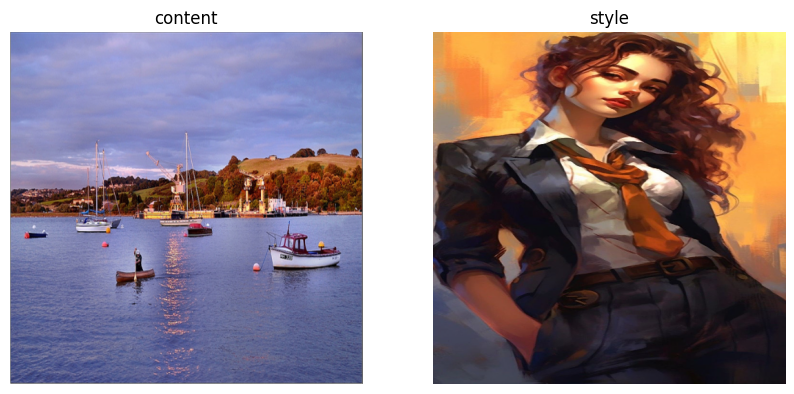

In [23]:
dataset_test = ImagePairDataset("../../../data/coco", "../../../data/styles", transform_test)
# random_idx = random.randint(0, len(dataset_test)-1)
# print(random_idx)
# content, style = dataset_test[random_idx]
content = transform_test(image=dataset_test.get_content_img(63485)[0])['image']
style = transform_test(image=cv2.imread('../../../data/styles/10 Pop Stars Of The Early 2000’s If They Were Dolls, Made With Ai (13 Pics).jpg')[:, :, ::-1])['image']


# content = transform_test(image=cv2.imread('../../../data/contents/101.jpg')[:, :, ::-1])['image']
# style = transform_test(image=cv2.imread('../../../data/styles/starry.jpg')[:, :, ::-1])['image']

plt.figure(figsize=(10,10))
plt.subplot(1, 2, 1)
plt.title("content")
plt.axis('off')
plt.imshow(denormalization(content.permute(1, 2, 0).numpy()))
plt.subplot(1, 2, 2)
plt.title("style")
plt.axis('off')
plt.imshow(denormalization(style.permute(1, 2, 0).numpy()))

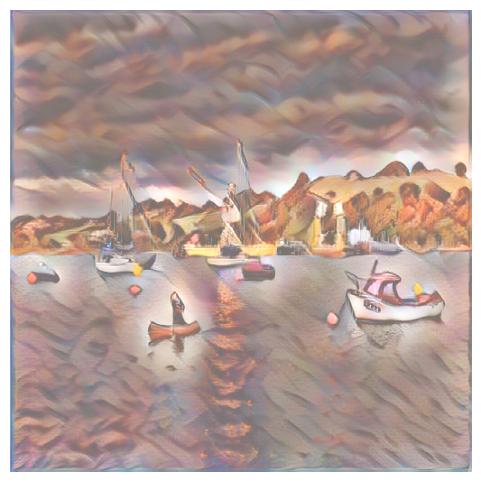

In [124]:
# n = 30000, lambda = 5
model.eval()
with torch.no_grad():
  generated = model(content.unsqueeze(0).to(device), style.unsqueeze(0).to(device))
  generated = denormalization(generated[0].permute(1,2,0).detach().cpu().numpy())
  plt.figure(figsize=(6,6))
  plt.axis('off')
  plt.imshow(generated)

## style weighting

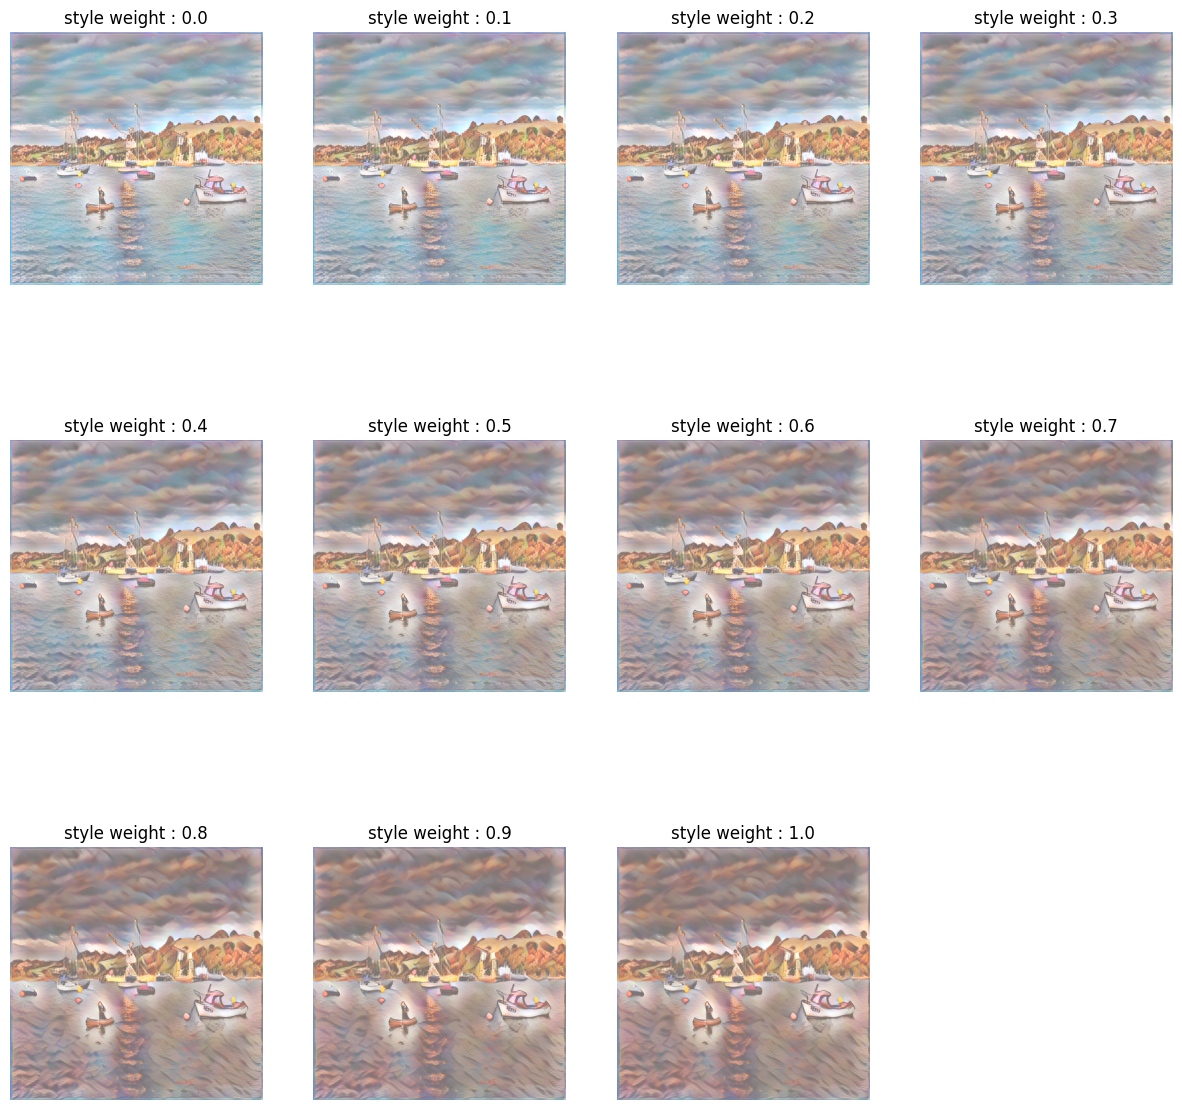

In [146]:
model.eval()
with torch.no_grad():
  plt.figure(figsize=(15, 15))
  for i, weight in enumerate(np.arange(0, 1.1, 0.1)):
    weight = weight.round(1)
    generated = model(content.unsqueeze(0).to(device), style.unsqueeze(0).to(device), alpha=weight)
    plt.subplot(3, 4, i+1)
    plt.axis('off')
    plt.title(f'style weight : {weight}')
    plt.imshow(denormalization(generated[0].permute(1,2,0).detach().cpu().numpy()))

## Style interpolation

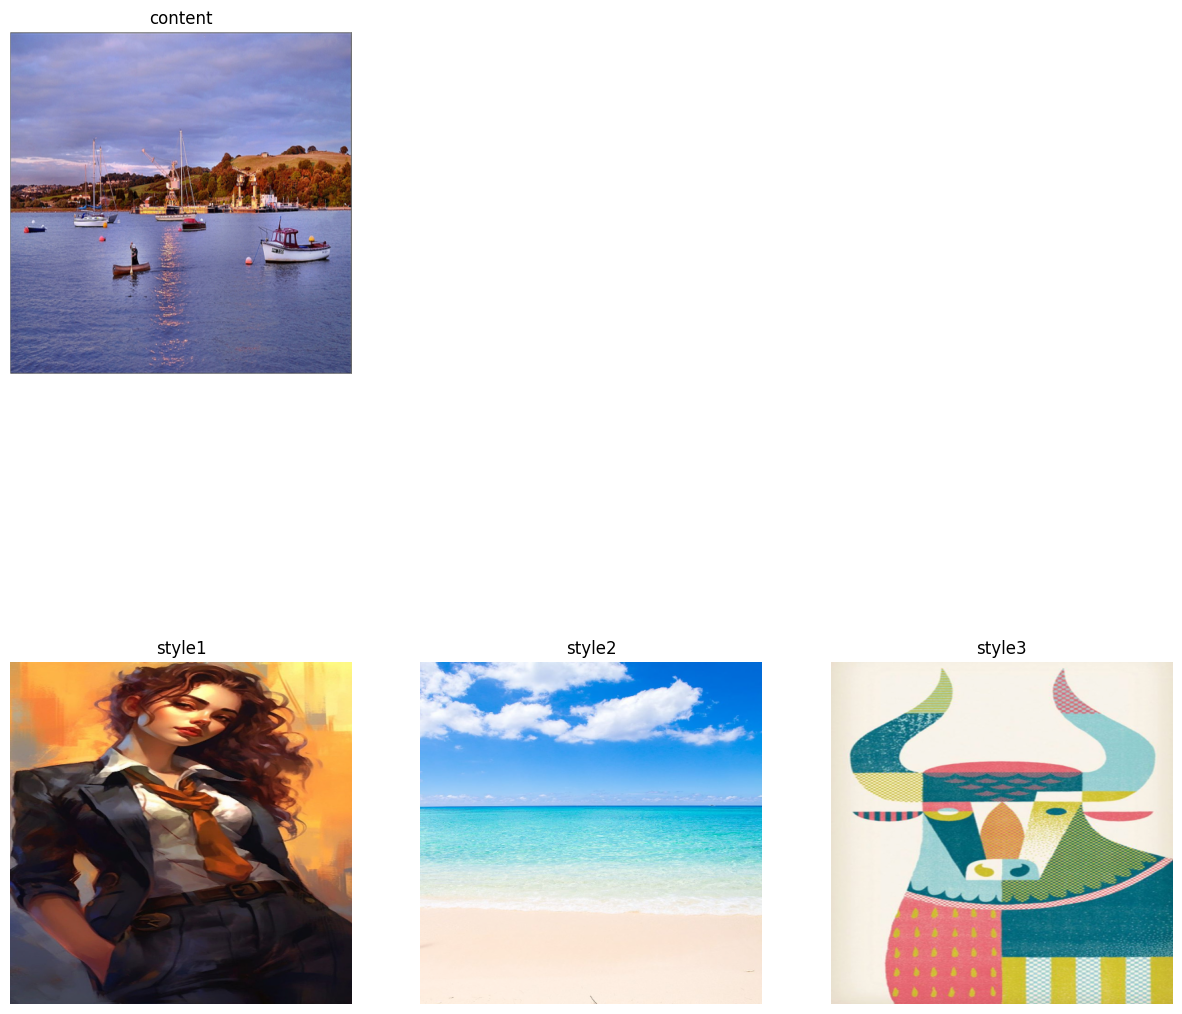

In [116]:
# content_1, style_1 = dataset_test[random.randint(0, len(dataset_test)-1)]
# style_2 = transform_test(image=dataset_test.get_style_img()[0])['image']
# style_3 = transform_test(image=dataset_test.get_style_img()[0])['image']
style_2 = transform_test(image=cv2.imread('../../../data/styles./A Memorable 6 Day Western Caribbean Cruise On Carnival Vista.jpg')[:, :, ::-1])['image']
style_3 = transform_test(image=cv2.imread('../../../data/styles/Ox Painting Project for Kids - 2021 Year of the Ox.jpg')[:, :, ::-1])['image']

fig = plt.figure(figsize=(15,15))
plt.subplot(2, 3, 1)
plt.title("content")
plt.axis('off')
plt.imshow(denormalization(content.permute(1, 2, 0).numpy()))
plt.subplot(2, 3, 4)
plt.title("style1")
plt.axis('off')
plt.imshow(denormalization(style.permute(1, 2, 0).numpy()))
plt.subplot(2, 3, 5)
plt.title("style2")
plt.axis('off')
plt.imshow(denormalization(style_2.permute(1, 2, 0).numpy()))
plt.subplot(2, 3, 6)
plt.title("style3") 
plt.axis('off')
plt.imshow(denormalization(style_3.permute(1, 2, 0).numpy()))

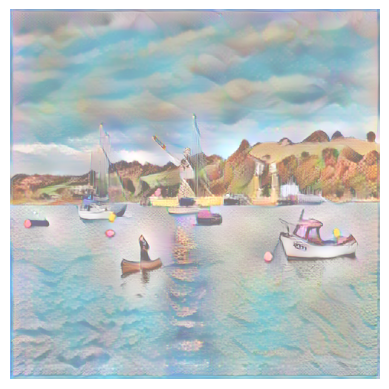

In [162]:
weights = np.array([0.33, 0.33, 0.33])
weights /= sum(weights)

generated = model.style_interpolation_forward(
    content.unsqueeze(0).to(device), 
    torch.stack([style, style_2, style_3]).to(device), 
    weights,
)
plt.axis('off')
plt.imshow(denormalization(tensor_2_np(generated)).clip(0, 1))

## space preservation

In [ ]:
# data/coco/train2017/000000312790.jpg

In [ ]:
# masked = np.where(upper_mask < 255, 0, upper_mask)
# total = (masked > 0).sum(2, keepdims=True)
# total = np.where(np.logical_and(total > 0, total < 3), 255, masked)
# cv2.imwrite('a.jpg', total)

True

In [40]:
transform_mask = A.Compose([
    A.Resize(512, 512),
    A.Normalize(0,1),
    ToTensorV2(),
])

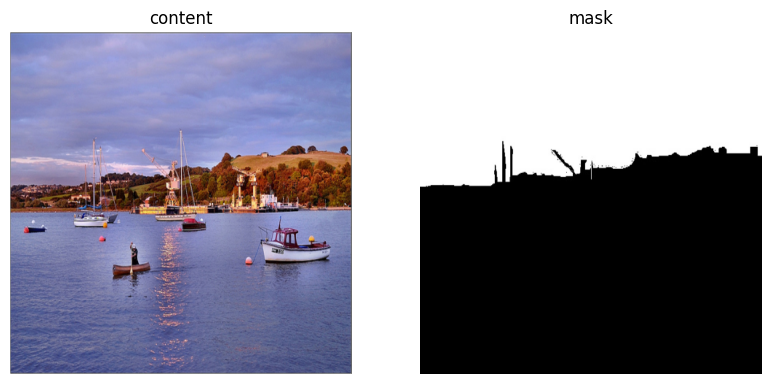

In [64]:
upper_mask = transform_mask(image=cv2.imread('./artifacts/upper_mask.jpg')[:, :, ::-1])['image']
fig = plt.figure(figsize=(15, 15))
plt.subplot(1, 3, 1)
plt.title("content")
plt.axis('off')
plt.imshow(denormalization(content.permute(1, 2, 0).numpy()))
plt.subplot(1, 3, 2)
plt.title("mask")
plt.axis('off')
plt.imshow(upper_mask.permute(1, 2, 0).numpy())

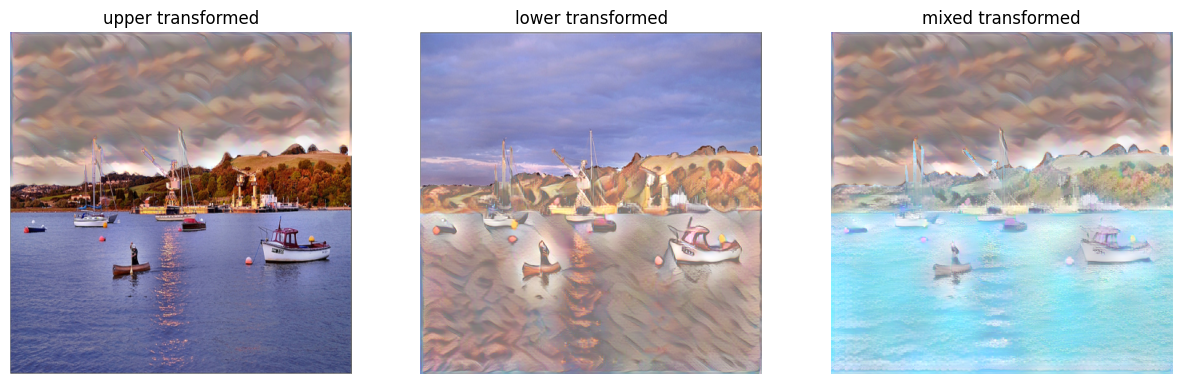

In [65]:
generated = model(
    content.unsqueeze(0).to(device), 
    style.unsqueeze(0).to(device),
)
generated2 = model(
    content.unsqueeze(0).to(device), 
    style_2.unsqueeze(0).to(device),
)
lower_preserved = generated * upper_mask.unsqueeze(0).to(device) + content.unsqueeze(0).to(device) * (1 - upper_mask.unsqueeze(0).to(device))
upper_preserved = generated * (1 - upper_mask.unsqueeze(0).to(device)) + content.unsqueeze(0).to(device) * upper_mask.unsqueeze(0).to(device)
mixed_preserved = generated * upper_mask.unsqueeze(0).to(device) + generated2 * (1 - upper_mask.unsqueeze(0).to(device))

plt.figure(figsize=(15, 15))
plt.subplot(1, 3, 1)
plt.title("upper transformed")
plt.axis('off')
plt.imshow(denormalization(tensor_2_np(lower_preserved)).clip(0, 1))
plt.subplot(1, 3, 2)
plt.title("lower transformed")
plt.axis('off')
plt.imshow(denormalization(tensor_2_np(upper_preserved)).clip(0, 1))
plt.subplot(1, 3, 3)
plt.title("mixed transformed")
plt.axis('off')
plt.imshow(denormalization(tensor_2_np(mixed_preserved)).clip(0, 1))

## color preservation

In [79]:
def YIQ_transform(x: torch.Tensor) -> torch.Tensor:
    n, c, _, _ = x.shape

    A = torch.Tensor([
        [.299, .587, .114],
        [.596, -.274, -.322],
        [.211, -.523, .312],
    ]).view(1, 3, 3)
    
    return torch.bmm(A, x.reshape(n, c, -1)).reshape(x.shape)

In [83]:
def YIQ_inverse_transform(x: torch.Tensor) -> torch.Tensor:
    n, c, _, _ = x.shape

    A = torch.Tensor([
        [.299, .587, .114],
        [.596, -.274, -.322],
        [.211, -.523, .312],
    ]).inverse().view(1, 3, 3)
    
    return torch.bmm(A, x.reshape(n, c, -1)).reshape(x.shape)

In [84]:
# YIQ_transform(content.unsqueeze(0)).shape
# YIQ_inverse_transform(content.unsqueeze(0)).shape

torch.Size([1, 3, 512, 512])

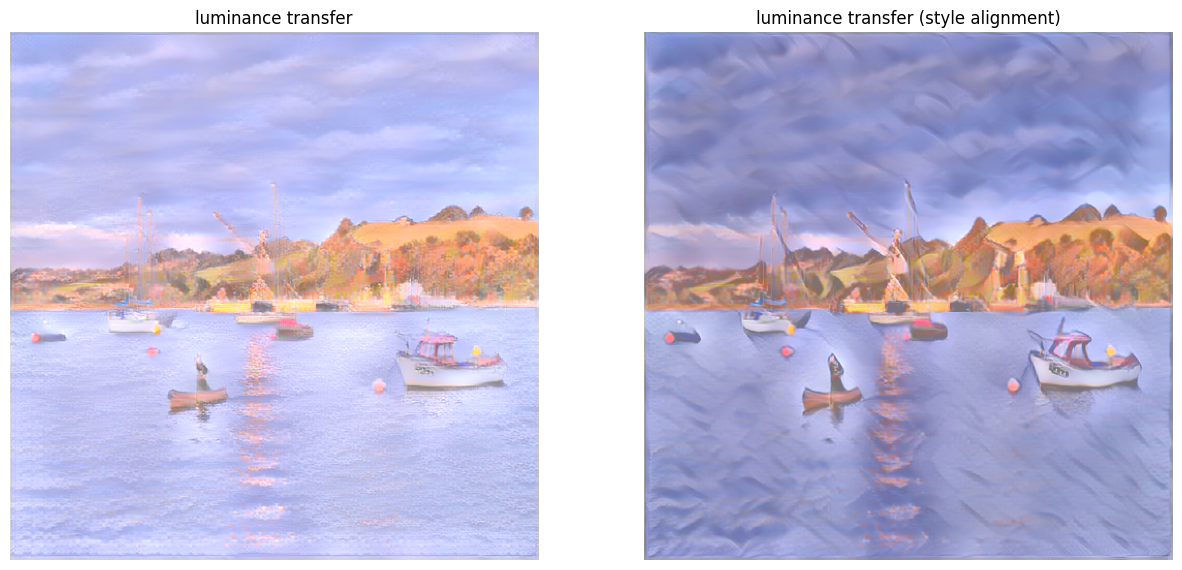

In [95]:
plt.figure(figsize=(15,15))

generated = model(
    content.unsqueeze(0).to(device), 
    style_2.unsqueeze(0).to(device),
)
generated_yiq = YIQ_transform(generated.detach().cpu())
content_yiq = YIQ_transform(content.unsqueeze(0))

generated_yiq[:, 1:3, :, :] = content_yiq[:, 1:3, :, :]

luminance_transfer = YIQ_inverse_transform(generated_yiq)

plt.subplot(1, 2, 1)
plt.title("luminance transfer")
plt.axis('off')
plt.imshow(denormalization(tensor_2_np(luminance_transfer)).clip(0, 1))

# standardization alignment
style_yiq = YIQ_transform(style.unsqueeze(0))
normalization = AdaptiveInstanceNormalization(style_yiq[:, 0:1, :, :], content_yiq[:, 0:1, :, :])
style_yiq[:, 0:1, :, :] = normalization(style_yiq[:, 0:1, :, :])
style_yiq_align = YIQ_inverse_transform(style_yiq)

generated = model(
    content.unsqueeze(0).to(device), 
    style_yiq_align.to(device),
)
generated_yiq = YIQ_transform(generated.detach().cpu())

generated_yiq[:, 1:3, :, :] = content_yiq[:, 1:3, :, :]

luminance_transfer = YIQ_inverse_transform(generated_yiq)

plt.subplot(1, 2, 2)
plt.title("luminance transfer (style alignment)")
plt.axis('off')
plt.imshow(denormalization(tensor_2_np(luminance_transfer)).clip(0, 1))

In [113]:
def color_histogram_matching(style: torch.Tensor, content: torch.Tensor) -> torch.Tensor:
    n, c, _, _ = style.shape
    
    x, y = style.reshape(n, c, -1), content.reshape(n, c, -1)
    
    mu_x, mu_y = x.mean(2, keepdim=True), y.mean(2, keepdim=True)
    cov_x = torch.bmm(x - mu_x , (x - mu_x).transpose(1, 2)) / x.numel()
    cov_y = torch.bmm(y - mu_y , (y - mu_y).transpose(1, 2)) / y.numel()
    
    eta_x, eig_x = torch.linalg.eig(cov_x)
    eta_y, eig_y = torch.linalg.eig(cov_y)
    
    cov_half_x = torch.bmm(torch.bmm(eig_x, eta_x.diag_embed().sqrt()), eig_x.transpose(1, 2))
    cov_half_y = torch.bmm(torch.bmm(eig_y, eta_y.diag_embed().sqrt()), eig_y.transpose(1, 2))

    A = torch.bmm(cov_half_y, cov_half_x.inverse()).real
    
    print(A)
    
    return torch.bmm(A, style.reshape(n, c, -1)).reshape(style.shape) + mu_y.unsqueeze(3) - torch.bmm(A, mu_x).unsqueeze(3)

tensor([[[ 0.4234, -0.1022,  0.1604],
         [-0.0782,  0.3269,  0.6268],
         [-0.0760, -0.3084,  1.9957]]])


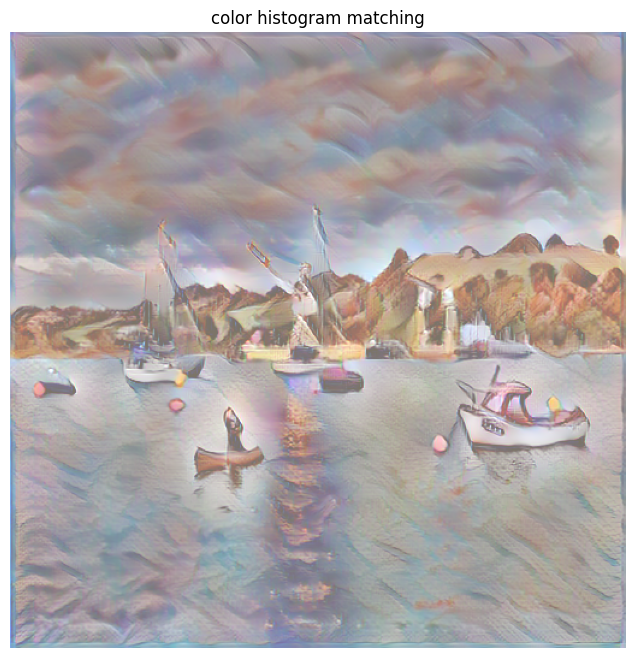

In [119]:
style_align = color_histogram_matching(style.unsqueeze(0), content.unsqueeze(0))
generated = model(
    content.unsqueeze(0).to(device), 
    style_align.to(device),
)
plt.figure(figsize=(8,8))
plt.title("color histogram matching")
plt.axis('off')
plt.imshow(denormalization(tensor_2_np(generated)).clip(0, 1))